---
## Table of Content
    # Load packages
    # Neural Network building
    # Function definitions
    # Load datasets (training and testing dataset)
    # Fine-tune model
        # KNN
        # Logistic
        # Random Forest
        # Neural Network (MLP)
    # Run experiment
        # Learning Curve
        # Confusion Matrix
        # Prediction Speed

---
# CIFAR-10 Final Report

---
# Packages

In [92]:
# load packages

# Classifiers: KNN, Logistic, RandomForest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Classifier: Neural Network
import torch.nn as nn
import torch.nn.functional as F

# Finetuning
from sklearn.model_selection import cross_val_score
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

# Metric: Accuracy, Confusion Matrix, Prediction Speed
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import time

# Visualization
import matplotlib.pyplot as plt

# Data pre-processing
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, learning_curve


# Data Acquisition
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset, DataLoader

seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

---
# Neural Network Building

In [24]:
class ConNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def fit(self, device, tr_loader, optimizer, criterion, epochs):
        self.train()
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

        for epoch in range(epochs):
            for X_tr, y_tr in tr_loader:
                X_tr, y_tr = X_tr.to(device), y_tr.to(device)
                optimizer.zero_grad()
                output = self(X_tr)
                loss = criterion(output, y_tr)
                loss.backward()
                optimizer.step()
                
            scheduler.step()

    
    def predict(self, device, loader):
        self.eval()  # Set model to evaluation mode
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for X_te, y_te in loader:
                X_te, y_te = X_te.to(device), y_te.to(device)
                output = self(X_te)
                preds = output.argmax(dim=1, keepdim=True)
                all_preds.extend(preds.cpu().numpy().flatten())
                all_labels.extend(y_te.cpu().numpy())

        return np.array(all_preds), np.array(all_labels)

    def compute_accuracy(self, y_pre, y_true):
        correct = (y_true == y_pre).sum()
        total = len(y_true)
        return correct / total


---
# Function definitions

In [32]:
def convert_to_numpy(dataloader):
    data, labels = [], []
    for i, j in dataloader:
        data.append(i.view(i.size(0), -1).numpy())
        labels.append(j.numpy())
    data = np.concatenate(data)
    labels = np.concatenate(labels)
    return data, labels

def prepare_corpus(trainset:torchvision.datasets, testset:torchvision.datasets):
    """
    return standard scaled X and Y datasets
    """
    # select only part of the dataset (for efficiency)
    train_indices = list(range(10000)) 
    test_indices = list(range(2000))  
    # take subset
    train_subset = Subset(trainset, train_indices)
    test_subset = Subset(testset, test_indices)

    batch_size = 4
    subset_trainloader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
    subset_testloader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=2)
    # for loading full training and testing dataset
    # full_trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    # full_testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    X_train, y_train = convert_to_numpy(subset_trainloader)
    X_test, y_test = convert_to_numpy(subset_testloader)

    # X_full_train, y_full_train = convert_to_numpy(full_trainloader)
    # X_full_test, y_full_test = convert_to_numpy(full_testloader)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # X_full_train = scaler.fit_transform(X_full_train)
    # X_full_test = scaler.transform(X_full_test)

    return X_train, y_train, X_test, y_test

In [74]:
def errors_for_train_sizes(clf, train_sizes, X_tr, y_tr, X_te, y_te):
    tr_err = [] 
    te_err = [] 

    for i in train_sizes:
        clf.fit(X_tr[:i], y_tr[:i])

        y_pred_tr = clf.predict(X_tr[:i])
        tr_err.append(1 - accuracy_score(y_tr[:i], y_pred_tr))

        y_pred_te = clf.predict(X_te)
        te_err.append(1 - accuracy_score(y_te, y_pred_te))

    return tr_err, te_err

def errors_for_train_sizes_cnn(tr_set, te_loader, train_sizes):
    tr_err_cnn = [] # training error for CNN
    te_err_cnn = [] # testing error for CNN

    
    for size in train_sizes:
        indices = list(range(size))
        tr_subset = Subset(tr_set, indices)
        tr_loader = DataLoader(tr_subset, batch_size=batch_size, shuffle=True, num_workers=2)
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        cnn = ConNeuralNetwork().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)
        
        # Train model
        cnn.fit(device, tr_loader, optimizer, criterion, epochs=20)
        
        # Training error
        y_pred_train, y_true_train = cnn.predict(device, tr_loader)
        train_accuracy = cnn.compute_accuracy(y_pred_train, y_true_train)
        train_error = 1 - train_accuracy
        tr_err_cnn.append(train_error)
        
        # Testing error
        y_pred_test, y_true_test = cnn.predict(device, te_loader)
        test_accuracy = cnn.compute_accuracy(y_pred_test, y_true_test)
        test_error = 1 - test_accuracy
        te_err_cnn.append(test_error)

    return tr_err_cnn, te_err_cnn

def plot_errors_for_train_sizes(name:str, train_sizes, tr_err, te_err):
    plt.semilogx(train_sizes, tr_err, label='Train', marker='x', linestyle='-', color='blue')
    plt.semilogx(train_sizes, te_err, label='Test', marker='x', linestyle='--', color='blue')

    plt.xlabel('Number of Training Data Points')
    plt.ylabel('Error Rate')
    plt.legend()
    plt.title(f'Error rate vs training data points for {name}')
    plt.show()

def reportLearningCurve(clf, name:str, train_sizes, X_train, y_train, X_test, y_test):
    tr_err, te_err = errors_for_train_sizes(clf, train_sizes, X_train, y_train, X_test, y_test)
    plot_errors_for_train_sizes(name, train_sizes, tr_err, te_err)

In [95]:
def reportConfusionMatrix(clf, name:str, X_test, y_test):
    y_prediction = clf.predict(X_test)
    confusion_matrix_ = confusion_matrix(y_test, y_prediction)
    display:ConfusionMatrixDisplay = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_, display_labels=classes)
    display.plot()
    plt.title(f"Confusion Matrix for {name}")
    plt.show()

def reportConfusionMatrixCNN(model, loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    y_pre, y_te = model.predict(device, loader)

    cm = confusion_matrix(y_te, y_pre)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm)
    disp.plot()
    plt.title(f"Confusion Matrix for CNN")

In [90]:
def reportPredictionTime(clf, name:str, X_test):
    start = time.time()
    predictions = clf.predict(X_test)
    end = time.time()

    prediction_time = end - start
    time_per_image = prediction_time / len(X_test)
    print(f"Average prediction time per image by {name}: {time_per_image:.6f} seconds")

def reportPredictionTimeCNN(model, te_loader, subset):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    start_time = time.time()
    y_pre, y_true = model.predict(device, te_loader)
    end_time = time.time()
    prediction_time = end_time - start_time
    time_per_image = prediction_time / len(subset)
    print(f"Average prediction time per image by CNN: {time_per_image:.6f} seconds")

---
# Load datasets

In [52]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
full_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
batch_size = 4
indices = list(range(10000))
tr_subset = Subset(full_trainset, indices)
indices = list(range(2000))
te_subset = Subset(full_testset, indices)

#Loads the training set
tr_loader = torch.utils.data.DataLoader(tr_subset, batch_size=batch_size,
                                           shuffle=True, num_workers=2)

# Load test set
te_loader = torch.utils.data.DataLoader(te_subset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
                                        
X_train, y_train, X_test, y_test = prepare_corpus(full_trainset, full_testset)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


---
# Fine tune models

---
Fine tune KNN via 5 fold validation

In [8]:
k_values = [1, 5, 10, 50]
k_accuracies = {}

# 5-fold cross-validation
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    accuracies = cross_val_score(knn, X_train, y_train, cv=5)
    k_accuracies[k] = accuracies
    for i in accuracies:
        print(f"k = {k}, accuracy = {i:.4f}")

best_k_value = k_values[np.argmax([np.mean(v) for k, v in sorted(k_accuracies.items())])]
knn = KNeighborsClassifier(n_neighbors=best_k_value)
knn.fit(X_train, y_train)

train_acc = accuracy_score(y_train, knn.predict(X_train))
test_acc = accuracy_score(y_test, knn.predict(X_test))

print(f"Best k value: {best_k_value}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

k = 1, accuracy = 0.2780
k = 1, accuracy = 0.2730
k = 1, accuracy = 0.2700
k = 1, accuracy = 0.2890
k = 1, accuracy = 0.2990
k = 5, accuracy = 0.2920
k = 5, accuracy = 0.2690
k = 5, accuracy = 0.2890
k = 5, accuracy = 0.2980
k = 5, accuracy = 0.2890
k = 10, accuracy = 0.2935
k = 10, accuracy = 0.2755
k = 10, accuracy = 0.2925
k = 10, accuracy = 0.2960
k = 10, accuracy = 0.2825
k = 50, accuracy = 0.2900
k = 50, accuracy = 0.2630
k = 50, accuracy = 0.2775
k = 50, accuracy = 0.2750
k = 50, accuracy = 0.2790
Best k value: 10, Train Accuracy: 0.3944, Test Accuracy: 0.2815


---
Fine tune Logistic via 5 fold validation

In [9]:
C_values = [0.01, 0.1, 1, 10, 100]
C_accuracies = {}

# 5-fold cross-validation
for C in C_values:
    lr = LogisticRegression(C=C, max_iter=5000, random_state=seed)
    accuracies = cross_val_score(lr, X_train, y_train, cv=5)
    C_accuracies[C] = accuracies
    for i in accuracies:
        print(f"C = {C}, accuracy = {i:.4f}")

best_C_value = C_values[np.argmax([np.mean(v) for C, v in sorted(C_accuracies.items())])]
lr = LogisticRegression(C=best_C_value, max_iter=5000, random_state=seed)
lr.fit(X_train, y_train)

train_acc = accuracy_score(y_train, lr.predict(X_train))
test_acc = accuracy_score(y_test, lr.predict(X_test))

print(f"Best C value: {best_C_value}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

C = 0.01, accuracy = 0.3545
C = 0.01, accuracy = 0.3565
C = 0.01, accuracy = 0.3675
C = 0.01, accuracy = 0.3475
C = 0.01, accuracy = 0.3510
C = 0.1, accuracy = 0.3150
C = 0.1, accuracy = 0.3055
C = 0.1, accuracy = 0.3115
C = 0.1, accuracy = 0.3000
C = 0.1, accuracy = 0.3105
C = 1, accuracy = 0.2835
C = 1, accuracy = 0.2695
C = 1, accuracy = 0.2800
C = 1, accuracy = 0.2655
C = 1, accuracy = 0.2835
C = 10, accuracy = 0.2630
C = 10, accuracy = 0.2480
C = 10, accuracy = 0.2580
C = 10, accuracy = 0.2430
C = 10, accuracy = 0.2615
C = 100, accuracy = 0.2640
C = 100, accuracy = 0.2455
C = 100, accuracy = 0.2550
C = 100, accuracy = 0.2425
C = 100, accuracy = 0.2520
Best C value: 0.01, Train Accuracy: 0.5916, Test Accuracy: 0.3510


---
Fine tune RandomForest via grid search

In [10]:
parameters = {
    "n_estimators" : [5,25,50,100],
    "min_samples_split" : [2,5,10],
    "min_samples_leaf" : [2,5,10]
}
record = dict()
for x in parameters["n_estimators"]:
    for y in parameters["min_samples_split"]:
        for z in parameters["min_samples_leaf"]:
            print(x,y,z, sep="      ")
            clf:RandomForestClassifier = RandomForestClassifier(n_estimators=x,
                                                    criterion = 'gini',
                                                    min_samples_split = y,
                                                    min_samples_leaf = z,
                                                    )
            clf.fit(X_train, y_train)
            acc = accuracy_score(y_test, clf.predict(X_test))
            record[acc] = record.get(acc, []) +[(x,y,z)]
            print("Accuracy: ", acc)

best_acc = max(record.keys())
best_model = record[best_acc]

print("Best model (hyper parameters): ", best_model, "Accuracy_score: ", best_acc )

5      2      2
Accuracy:  0.2755
5      2      5
Accuracy:  0.3075
5      2      10
Accuracy:  0.3285
5      5      2
Accuracy:  0.3095
5      5      5
Accuracy:  0.298
5      5      10
Accuracy:  0.3055
5      10      2
Accuracy:  0.3085
5      10      5
Accuracy:  0.295
5      10      10
Accuracy:  0.309
25      2      2
Accuracy:  0.381
25      2      5
Accuracy:  0.4015
25      2      10
Accuracy:  0.3875
25      5      2
Accuracy:  0.3865
25      5      5
Accuracy:  0.383
25      5      10
Accuracy:  0.3985
25      10      2
Accuracy:  0.396
25      10      5
Accuracy:  0.3925
25      10      10
Accuracy:  0.379
50      2      2
Accuracy:  0.406
50      2      5
Accuracy:  0.4195
50      2      10
Accuracy:  0.407
50      5      2
Accuracy:  0.4105
50      5      5
Accuracy:  0.4215
50      5      10
Accuracy:  0.4135
50      10      2
Accuracy:  0.4005
50      10      5
Accuracy:  0.415
50      10      10
Accuracy:  0.411
100      2      2
Accuracy:  0.4295
100      2      5
Acc

---
Fine tune neural network via Epoch

In [27]:
def find_best_epochs(epochs):
    best_epochs = None
    best_accuracy = 0.0
    cnn = ConNeuralNetwork()

    for epoch in epochs:
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        cnn.fit(device, tr_loader, optimizer, criterion, epochs=epoch)

        y_pre, y_true = cnn.predict(device, te_loader)

        accuracy = cnn.compute_accuracy(y_pre, y_true)
        print(f"Epochs: {epoch}, Accuracy: {accuracy}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_epochs = epoch

    print(f"Best Epochs: {best_epochs}, Best Accuracy: {best_accuracy}")
    return best_epochs

print(find_best_epochs([1, 5, 10, 20, 30]))

Epochs: 1, Accuracy: 0.2755
Epochs: 5, Accuracy: 0.4915
Epochs: 10, Accuracy: 0.4795
Epochs: 20, Accuracy: 0.5175
Epochs: 30, Accuracy: 0.5055
Best Epochs: 20, Best Accuracy: 0.5175
20


---
Fine tune neural network via Batch Size

In [14]:
X_tr = np.array([full_trainset[i][0].numpy() for i in range(len(full_trainset))])
y_tr = np.array([full_trainset[i][1] for i in range(len(full_trainset))])
X_te = np.array([full_testset[i][0].numpy() for i in range(len(full_testset))])
y_te = np.array([full_testset[i][1] for i in range(len(full_testset))])

def reshape_data(X_tr, X_te):

    X_tr_shaped = X_tr.reshape(X_tr.shape[0], -1)
    X_te_shaped = X_te.reshape(X_te.shape[0], -1)

    return X_tr_shaped, X_te_shaped

X_tr_shaped, X_te_shaped = reshape_data(X_tr, X_te)

def find_best_batch_size(X_tr, y_tr, X_te, y_te, batch_sizes, seed):
    best_batch_size = None
    best_accuracy = 0.0
    
    for batch_size in batch_sizes:
        mlp = MLPClassifier(hidden_layer_sizes=64, activation='relu', solver='adam', learning_rate_init=0.001, batch_size=batch_size, random_state=seed, max_iter=1000)
        
        mlp.fit(X_tr, y_tr)
    
        y_te_pred = mlp.predict(X_te)
        accuracy = accuracy_score(y_te, y_te_pred)
        
        print(f"Batch Size: {batch_size}, Accuracy: {accuracy}")
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_batch_size = batch_size
    
    print(f"Best Batch Size: {best_batch_size}, Best Accuracy: {best_accuracy}")
    return best_batch_size

batch_sizes = [32, 64, 128, 256]
find_best_batch_size(X_tr_shaped[:10000], y_tr[:10000], X_te_shaped[:2000], y_te[:2000], batch_sizes, seed)

Batch Size: 32, Accuracy: 0.3955
Batch Size: 64, Accuracy: 0.396
Batch Size: 128, Accuracy: 0.3965
Batch Size: 256, Accuracy: 0.3925
Best Batch Size: 128, Best Accuracy: 0.3965


128

---
# Performance Report

In [84]:
best_k = 10
best_C = 0.01
"hyperparameters for cnn: nn.CrossEntropyLoss(), optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9), epochs=20"

# set up fine tuned models
knn = KNeighborsClassifier(n_neighbors=best_k)
lr = LogisticRegression(C=best_C, max_iter=5000, random_state=seed)
rf = RandomForestClassifier(n_estimators=100, criterion = 'gini', min_samples_split = 5, min_samples_leaf = 5, random_state=seed)
mlp = MLPClassifier(hidden_layer_sizes=64, activation='relu', solver='adam', learning_rate_init=0.00001, batch_size=128, random_state=seed, max_iter=1000)
cnn = ConNeuralNetwork()
#neural = model

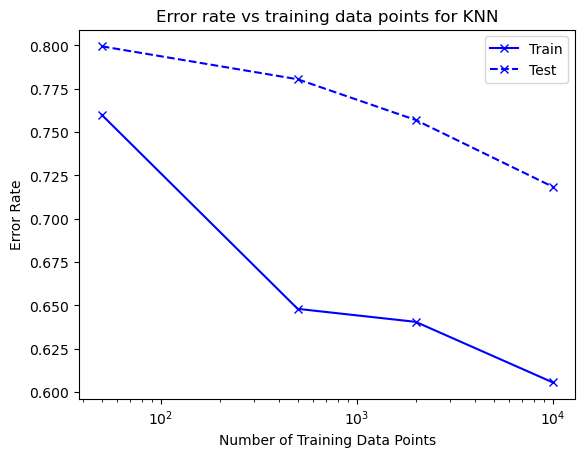

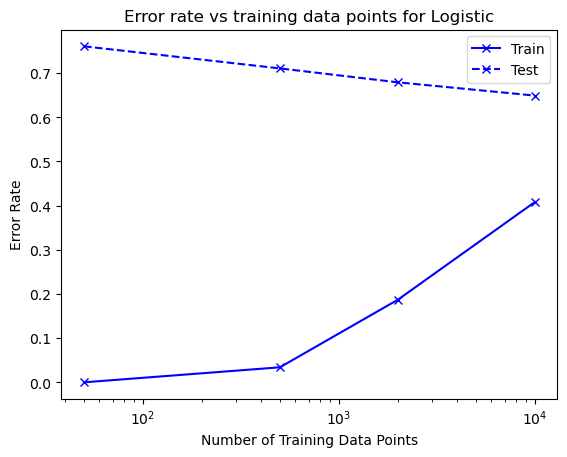

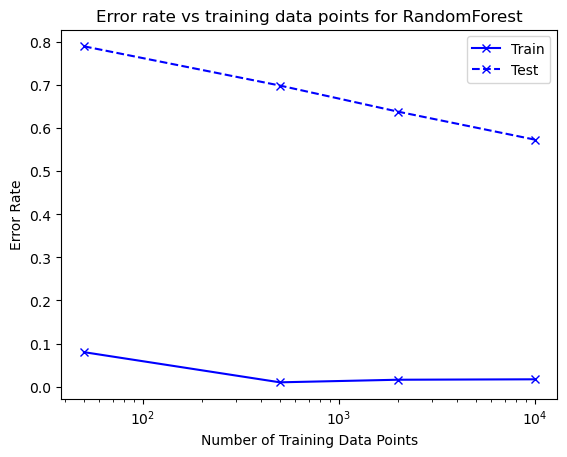

c:\Users\travi\miniconda3\envs\cs178\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:609: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn(
c:\Users\travi\miniconda3\envs\cs178\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\travi\miniconda3\envs\cs178\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\travi\miniconda3\envs\cs178\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


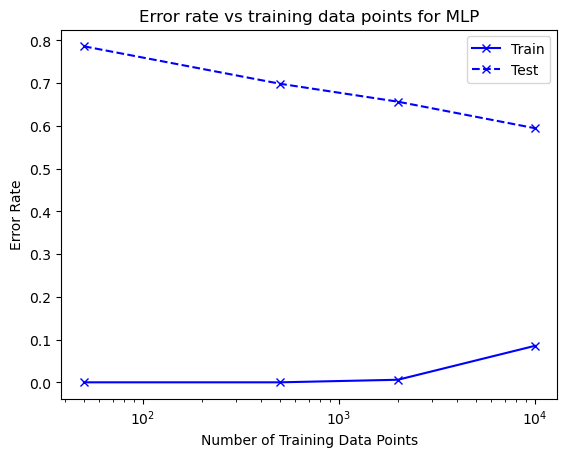

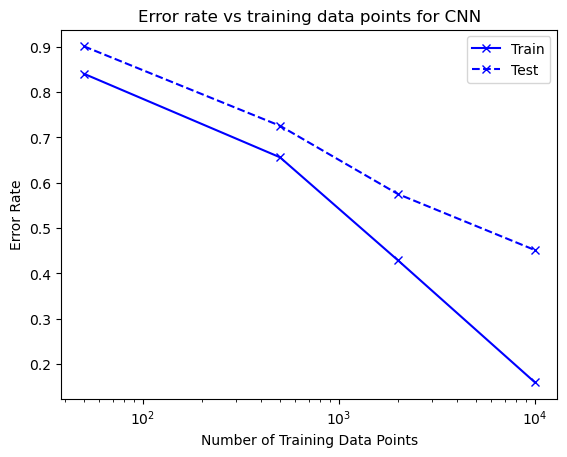

In [87]:
# report Learning curve
train_sizes = [50, 500, 2000, 10000]
reportLearningCurve(knn, "KNN", train_sizes, X_train, y_train, X_test, y_test)
reportLearningCurve(lr, "Logistic", train_sizes, X_train, y_train, X_test, y_test)
reportLearningCurve(rf, "RandomForest", train_sizes, X_train, y_train, X_test, y_test)
reportLearningCurve(mlp, "MLP", train_sizes, X_train, y_train, X_test, y_test)
tr_err_cnn, te_err_cnn = errors_for_train_sizes_cnn(full_trainset, te_loader, train_sizes)
plot_errors_for_train_sizes("CNN", train_sizes, tr_err_cnn, te_err_cnn)

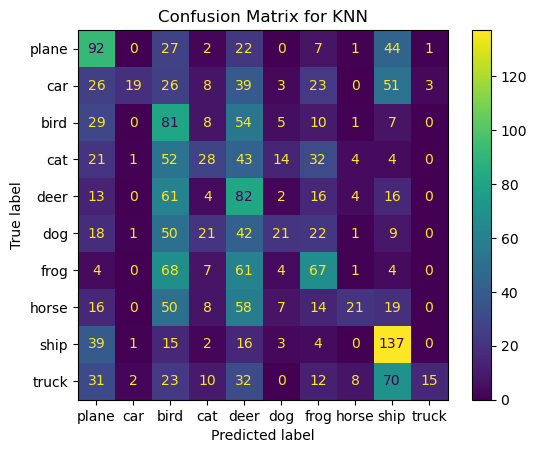

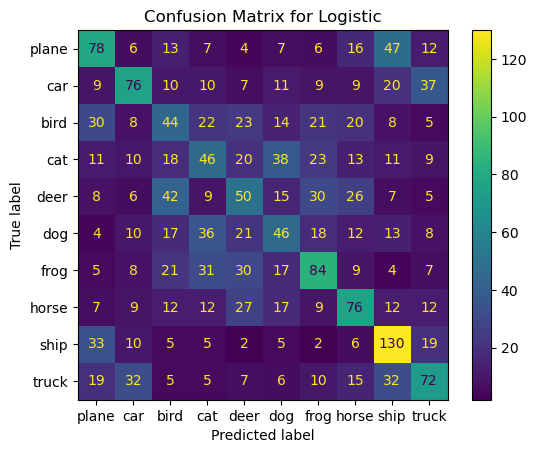

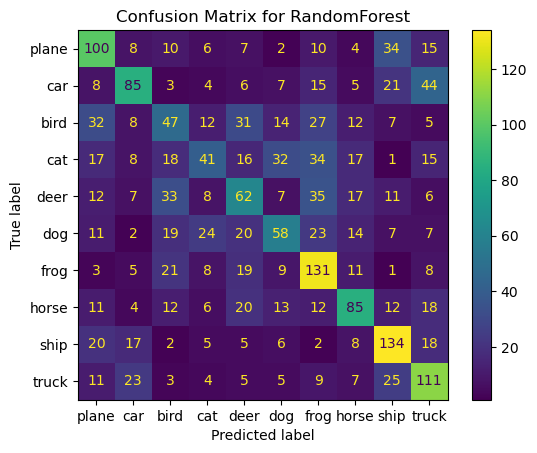

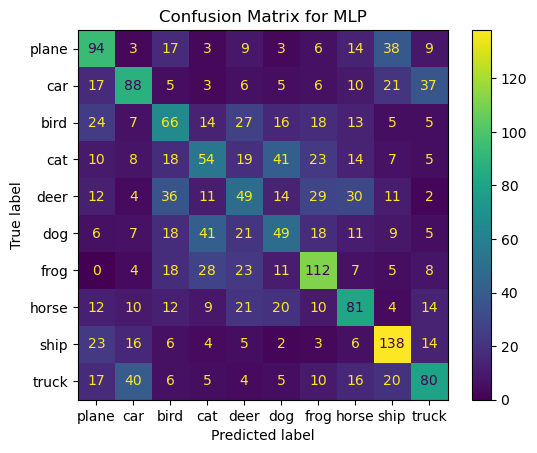

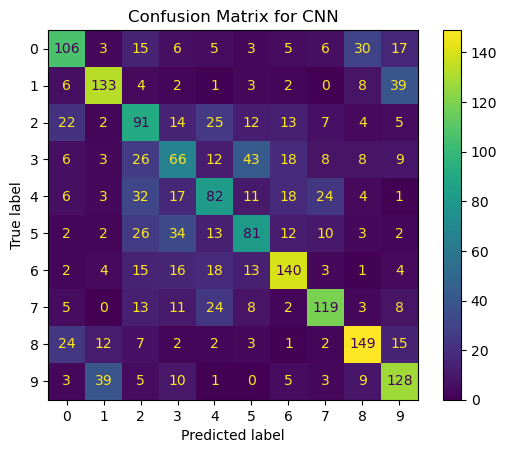

In [97]:
# report Confusion matrix
reportConfusionMatrix(knn, "KNN", X_test=X_test, y_test = y_test)
reportConfusionMatrix(lr, "Logistic", X_test=X_test, y_test = y_test)
reportConfusionMatrix(rf, "RandomForest", X_test=X_test, y_test = y_test)
reportConfusionMatrix(mlp, "MLP", X_test=X_test, y_test = y_test)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)
cnn.fit(device, tr_loader, optimizer, criterion, epochs=20)
reportConfusionMatrixCNN(cnn, te_loader)

In [98]:
# report Prediction speed
reportPredictionTime(knn, name = "KNN", X_test=X_test)
reportPredictionTime(lr, name = "Logistic", X_test=X_test)
reportPredictionTime(rf, name = "RandomForest", X_test=X_test)
reportPredictionTime(mlp, name = "MLPClassifier", X_test=X_test)
reportPredictionTimeCNN(cnn, te_loader, te_subset)

Average prediction time per image by KNN: 0.000841 seconds
Average prediction time per image by Logistic: 0.000015 seconds
Average prediction time per image by RandomForest: 0.000083 seconds
Average prediction time per image by MLPClassifier: 0.000008 seconds
Average prediction time per image by CNN: 0.003815 seconds
